<a href="https://colab.research.google.com/github/shams-mehdi/SPIB-plumed-masterclass-2022/blob/main/plumed_masterclass_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 0**: Download files. Bridges2 doesnt support pytorch version>1.5. Install appropriate pytroch version.

In [ ]:
!gdown --id 1nVUJdQkn0mmXU32FANFY9_XkJVYnKqW_
!unzip masterclass_SPIB_packet.zip

%cd masterclass_SPIB_packet/scripts

In [ ]:
!pip install torch==1.5.0

# **Step 1**: Change colab runtime to GPU hardware accelerator. Load trajectory for alanine dipeptide in vacuum.<br><br>Simulation length: 20.0 ns, T: 450K, data resolution: 0.05 ps. Two files:

---
 8 OPs (sin-cos of φ, ψ, θ, ω) trajectory data, should be used for training SPIB: ***trajectory_sincos.np***y<br>
 4 OPs raw trajectory (φ, ψ, θ, ω) should be used for SPIB initial state labelling: ***trajectory.npy***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



traj_sincos = np.load("../data/trajectory_sincos.npy")
traj_raw = np.load("../data/trajectory.npy")

/content/scripts


# **Step 2**: Visualize (φ, ψ) time series for the first 100.0 ps, and create a free energy plot for the entire trajectory.

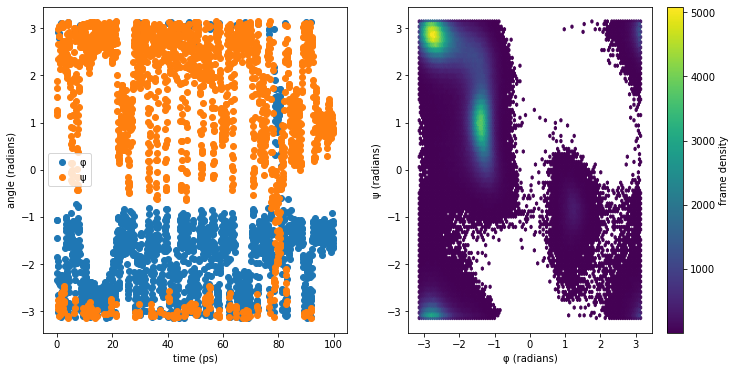

In [ ]:
## Loaded numpy arrays contain datapoints saved every 0.05ps. The first 2000 steps (100.00 ps) are selected for time series visualization
data_resolution = 0.05
datapoints_tseries = 2000
time = np.arange(datapoints_tseries)*data_resolution

fig, ax = plt.subplots(1, 2, figsize = (12,6))
## Time Series plot
ax[0].plot(time, traj_raw[:datapoints_tseries,0], 'o', label = 'φ')
ax[0].plot(time, traj_raw[:datapoints_tseries,1], 'o', label = 'ψ')
ax[0].set_xlabel('time (ps)')
ax[0].set_ylabel('angle (radians)')
ax[0].legend()

## FES plot of entire trajectory
fes = ax[1].hexbin(traj_raw[:,0], traj_raw[:,1], mincnt=1)
ax[1].set_xlabel('φ (radians)')
ax[1].set_ylabel('ψ (radians)')
cb = fig.colorbar(fes, ax=ax[1])
cb.set_label('frame density')

# **Step 3**: Initial state assignments by binning data along φ.

Text(0, 0.5, 'ψ (radians)')

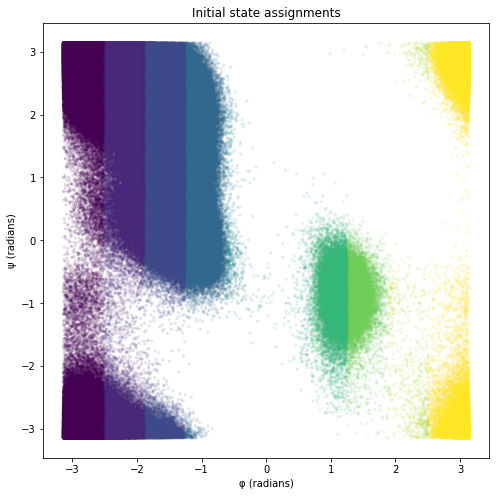

In [ ]:
#@title Plot and save one-hot encoded initial state assignments
num_labels = 10 #@param {type:"integer"}
## 10 initial states assigned to the trajectory by binning along φ

## Creating one hot vectors for initial states
bins = np.linspace(start = -np.pi, stop = np.pi, num = num_labels, endpoint = False)
binned_data = np.digitize(traj_raw[:,0], bins)-1
one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
one_hot_labels[np.arange(traj_raw.shape[0]),binned_data] = 1

## Save one-hot encoded initial states
np.save("../data/labels.npy", one_hot_labels)

## Visualize initial states
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(traj_raw[:, 0], traj_raw[:, 1], c=binned_data, s=5, alpha=.1)
ax.set_title('Initial state assignments')
ax.set_xlabel('φ (radians)')
ax.set_ylabel('ψ (radians)')

# **Step 4**: Train a nonlinear SPIB (ver July, 2021) model by choosing appropriate hyperparmeters.

---

Time delay = dt*0.05 ps, heuristic for batch size = 0.1% of trajectory length

In [ ]:
#@title Train model using following hyperparameters
## Train an SPIB model with time delay = 0.25 ps

dt = 5 #@param {type:"integer"}
rc_dim = 2 #@param {type:"integer"}
encoder_type = 'Nonlinear' #@param {type:"string"}
neuron_num1 = 16 #@param {type:"integer"}
neuron_num2 = 16 #@param {type:"integer"}
## heuristic for batch size is to set it ~ 0.1% of the trajectory length
batch_size = 2048 #@param {type:"integer"}
refinements = 15 #@param {type:"integer"}
learning_rate = 0.0001 #@param {type:"number"}
beta = 0.001 #@param {type:"number"}
seed = 0 #@param {type:"integer"}
traj_path = '../data/trajectory_sincos.npy'
initial_states_path = '../data/labels.npy'

!python test_model.py -dt {dt} -d {rc_dim} -encoder_type {encoder_type} -bs {batch_size} -n1 {neuron_num1} -n2 {neuron_num2} -refinements {refinements} -lr {learning_rate} -b {beta} -seed {seed} -label {initial_states_path} -traj {traj_path}

# ***Step 5***: Visualize converged labels obtained from SPIB

Text(0, 0.5, 'ψ (radians)')

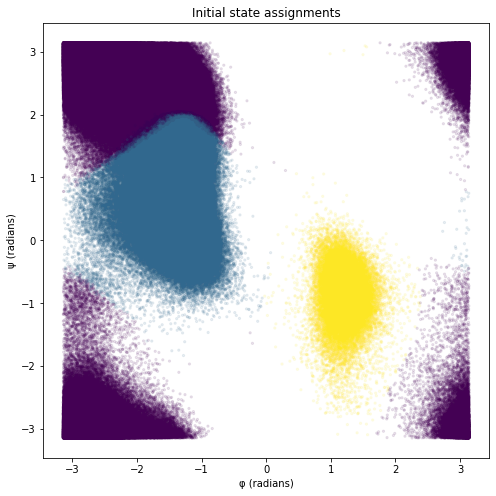

In [ ]:
#@title Setting some parameter values

import matplotlib.pyplot as plt
import numpy as np

SPIB_OPs = 8 #@param {type:"integer"}
Weighted_or_not = "Unweighted" #@param {type:"string"}

## Number of trajectories in this analysis
num_traj = 1
## Construct file path from chosen hyperparameter values
path = "SPIB/" + Weighted_or_not + "_d=" + str(rc_dim) + "_t=" + str(dt) + "_b=" + "{:.4f}".format(beta) + "_learn=" + "{:.6f}".format(learning_rate)

one_hot_converged_labels = np.load(path + "_traj" + str(num_traj-1) + "_labels" + str(seed) + ".npy")
converged_labels = np.zeros((one_hot_converged_labels.shape[0]), dtype = 'int')

for i in range(converged_labels.shape[0]):
  converged_labels[i] = np.nonzero(one_hot_converged_labels[i,:])[0]

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(traj_raw[:, 0], traj_raw[:, 1], c=converged_labels, s=5, alpha=.1)
ax.set_title('Initial state assignments')
ax.set_xlabel('φ (radians)')
ax.set_ylabel('ψ (radians)')

# **Step 6**: Extract and save SPIB model.

In [ ]:
#@title Read trained SPIB model and save another model containing just the encoder
# Note: When encountering following error: "module SPIB has no attribute SPIB", restart runtime.
import torch
from torch import nn
import SPIB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_shape=(SPIB_OPs,)
UpdateLabel = True
## Load patameters from SPIB checkpoint
restore_path= path + 'cpt0/IB_final_cpt.pt'
representative_inputs_path=path + '_representative_inputs' + str(seed) + '.npy'
representative_inputs = torch.tensor(np.load(representative_inputs_path))
IB = SPIB.SPIB(encoder_type, rc_dim, num_labels, data_shape, device, UpdateLabel, neuron_num1, neuron_num2)
IB.reset_representative(representative_inputs)

checkpoint=torch.load(restore_path)
IB.load_state_dict(checkpoint['state_dict'])

## Generate model
class RC_encoder(nn.Module):
    def __init__(self, encoder_type, IB, neuron_num1=128, neuron_num2=128):
        super(RC_encoder, self).__init__()
        if encoder_type == 'Nonlinear':
            self.encoder_type = 'Nonlinear'
        else:
            self.encoder_type = 'Linear'
        self.neuron_num1 = neuron_num1
        self.neuron_num2 = neuron_num2
        self.data_shape = data_shape

        if self.encoder_type == 'Nonlinear': 
            self.encoder = IB.encoder
        self.encoder_mean = IB.encoder_mean
    
    def forward(self, data):
        inputs = torch.flatten(data, start_dim=1)
        if self.encoder_type == 'Nonlinear': 
            enc = self.encoder(inputs)
            RC = self.encoder_mean(enc)
        else:
            RC = self.encoder_mean(inputs)
        return RC

# create RC_encoder and save model
IB_encoder = RC_encoder(encoder_type, IB, neuron_num1, neuron_num2)
fake_input = torch.zeros((1,)+data_shape)
mod = torch.jit.trace(IB_encoder, fake_input)
mod.save('model.pt')
print("Model saved successfully!")

Model saved successfully!


# **Step 7**: Generate Plumed input from saved model.

---
Sigma_mul, grid_mul defines how to calculate sigma and grid_min, grid_max from rc values. See code for details.


In [ ]:
#@title Metadynamics parameters
sigma_mul = 0.2 #@param {type:"number"}
grid_mul = 5 #@param {type:"number"}
height = 1.5 #@param {type:"number"}
bias_factor = 10 #@param {type:"number"}
pace = 2000 #@param {type:"integer"}
stride = 100 #@param {type:"integer"}
grid_bins = 500 #@param {type:"integer"}
file_name = "plumed_SPIB_aladip.dat" #@param {type:"string"}
dihedrals = ['phi', 'psi', 'theta', 'omega']
header = f"{dihedrals[0]}:  TORSION ATOMS=5,7,9,15       NOPBC\
          \n{dihedrals[1]}: TORSION ATOMS=7,9,15,17      NOPBC\
          \n{dihedrals[2]}: TORSION ATOMS=6,5,7,9        NOPBC\
          \n{dihedrals[3]}: TORSION ATOMS=9,15,17,19     NOPBC"

with open('header.txt', 'r') as f:
  head = f.read()

header = header + "\n" + head + "\n"

## Calculate standard deviation of the RC and mutiply by sigma_mul to obtain sigma for metadynamics
traj_rc = np.load(path + "_traj" + str(num_traj-1) + "_mean_representation" + str(seed) + ".npy")
rc1_sigma = np.std(traj_rc[:,0])*sigma_mul
rc2_sigma = np.std(traj_rc[:,1])*sigma_mul  

## Set grid_min and grid_max
rc1_grid_min = np.min(traj_rc[:,0]) - grid_mul*rc1_sigma
rc2_grid_min = np.min(traj_rc[:,1]) - grid_mul*rc1_sigma

rc1_grid_max = np.max(traj_rc[:,0]) + grid_mul*rc1_sigma
rc2_grid_max = np.max(traj_rc[:,1]) + grid_mul*rc1_sigma

with open(file_name, 'w') as f:
    f.writelines(header)
    f.write('\n')
    
    SPIB_OPs = ''
    for i in dihedrals:
      SPIB_OPs += "sin_" + i + ",cos_" + i +","
    
    SPIB_OPs = SPIB_OPs[:-1]
    f.write('\n')
    
    f.write('# load pytorch model\n')
    f.write('deep: PYTORCH_MODEL MODEL=model.pt ARG='+SPIB_OPs+'\n')
    
    f.write('\n')
    

    f.write('# load metaD\n')
    f.write(f'METAD ...\nLABEL=metad\nARG=deep.node-0,deep.node-1 SIGMA={rc1_sigma},{rc2_sigma} HEIGHT={height} BIASFACTOR={bias_factor} TEMP=450.0 PACE={pace}\nGRID_MIN={rc1_grid_min},{rc2_grid_min} GRID_MAX={rc1_grid_max},{rc2_grid_max} GRID_BIN={grid_bins},{grid_bins}\nCALC_RCT RCT_USTRIDE=1\n... METAD')
    f.write('\n')
            
    f.write('\nPRINT ARG='+SPIB_OPs+'deep.node-0,deep.node-1,metad.bias,metad.rbias'+f' STRIDE={stride} FILE=COLVAR')
    
    f.write('\nDUMPMASSCHARGE FILE=mcfile')
    

# **Step 8:** Visualize SPIB augmentented metadynamics result (2.5 ns φ time series)

Text(0, 0.5, 'φ (radians)')

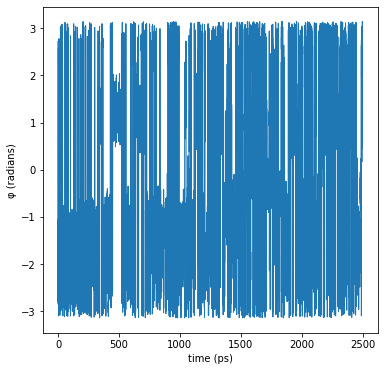

In [ ]:
## 8 OP SPIB-metadynamics COLVAR was converted to 4 OP numpy array (SPIB_metad_traj.npy)
SPIB_traj = np.load('SPIB_metad_traj.npy')
SPIB_data_resolution = 0.2
SPIB_time = np.arange(SPIB_traj.shape[0])*SPIB_data_resolution
fig, ax = plt.subplots(figsize = (6,6))
## Time Series plot
ax.plot(SPIB_time, SPIB_traj[:,0], linewidth = 1)
ax.set_xlabel('time (ps)')
ax.set_ylabel('φ (radians)')

# Notes: Copy following files to simulation directory:

*   plumed_SPIB_aladip.dat
*   model.pt
*   PytorchModel.cpp




# **Code tested for following modules:**

---

*   pytorch 1.5 for SPIB training (older pytorch version 1.5 was used as many HPCs e.g, bridges2 doesnt support more recent pytorch version)

*   plumed 2.5.7